## LSTM Auto-Encoder-Decoder for Anomaly Detection: 

## Detect anomalous points on time series data of cpu utilization

In [1]:
import numpy as np
import pandas as pd

from keras.layers import RepeatVector
from keras.layers.core import Dropout, Dense, Activation
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(23)

In [3]:
df = pd.read_csv('nyc_taxi.csv', parse_dates=['timestamp'], index_col='timestamp')

In [4]:
df.head(3)

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210


In [5]:
df.index.min()

Timestamp('2014-07-01 00:00:00')

In [6]:
df.index.max()

Timestamp('2015-01-31 23:30:00')

In [7]:
# How many data points?
len(df)

10320

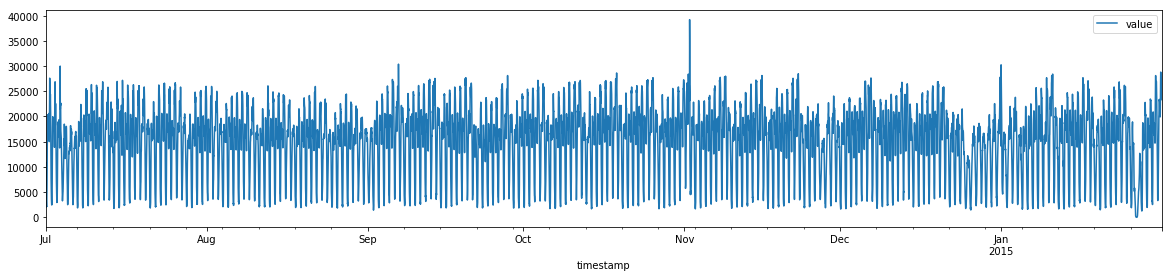

In [8]:
df = df['2014-07-01':'2015-01-31']
df.plot(figsize=(20,4));

In [9]:
from sklearn.preprocessing import StandardScaler

df['value'] = df['value'].astype(np.float64)

# Normalize the  data (center around 0 and scale to remove the variance).
scaler = StandardScaler()
df['value'] = scaler.fit_transform(df['value'].values.reshape(-1, 1))

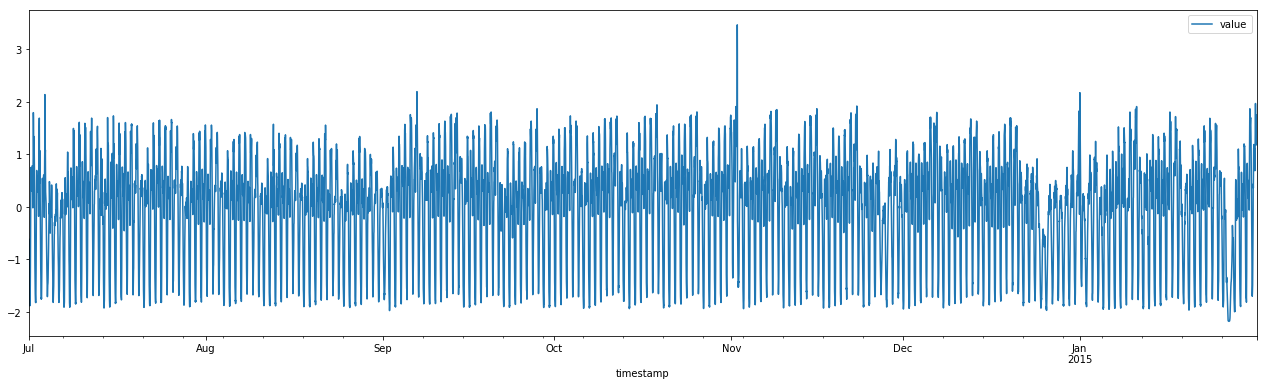

In [10]:
df.plot(figsize=(22,6));

### Create the training, validation and test sets

In [11]:
signal_train = df['2014-07-01':'2014-10-31'].values # July to October
signal_valid = df['2014-12-01':'2014-12-31'].values # December
signal_test = df['2014-11-01':'2014-11-30'].values # November

**Prepare Training Sequences: Create windows of 48 data points each**

In [12]:
window_length = 12 # Why 48? 24 readings in a day, so took for 2 days

In [13]:
train_windows = []

In [14]:
for window_start in range(0, len(signal_train) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_train[window_range])
    train_windows.append(window)

In [15]:
# length of training set
len(train_windows)

5893

In [16]:
#x_train = np.expand_dims(np.array(train_windows), axis=2)
#x_train.shape

In [17]:
# shape of training set
x_train = np.array(train_windows)
x_train.shape

(5893, 12, 1)

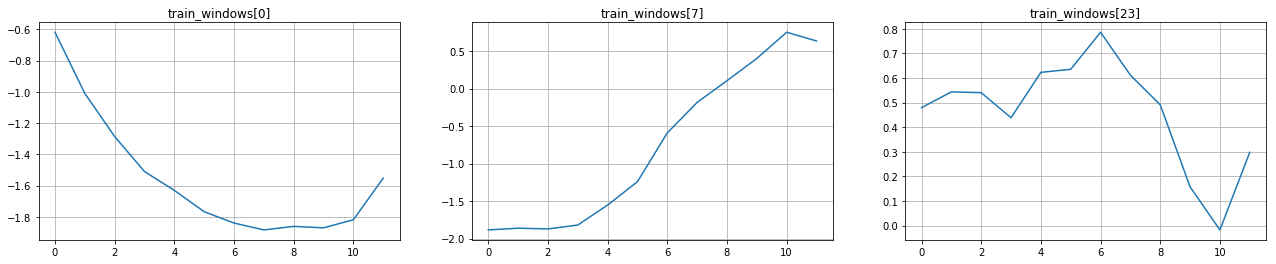

In [18]:
# Visualize the training sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(train_windows[0])
plt.title('train_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(train_windows[7])
plt.title('train_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(train_windows[23])
plt.title('train_windows[23]')
plt.grid(True)
plt.show();

**Prepare Validation Sequences: Create windows of 48 data points each**

In [19]:
valid_windows = []

In [20]:
for window_start in range(0, len(signal_valid) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_valid[window_range])
    valid_windows.append(window)

In [21]:
#x_valid = np.expand_dims(np.array(valid_windows), axis=2)
#x_valid.shape

In [22]:
# shape of validation set
x_valid = np.array(valid_windows)
x_valid.shape

(1477, 12, 1)

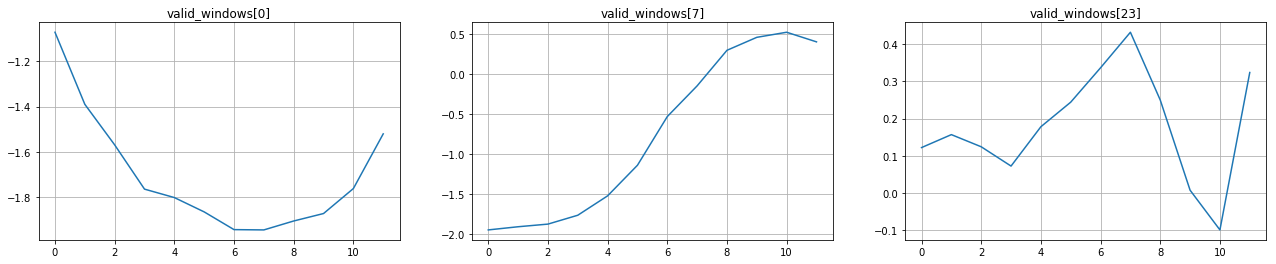

In [23]:
# Visualize the validation sequences
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(valid_windows[0])
plt.title('valid_windows[0]')
plt.grid(True)
plt.subplot(132)
plt.plot(valid_windows[7])
plt.title('valid_windows[7]')
plt.grid(True)
plt.subplot(133)
plt.plot(valid_windows[23])
plt.title('valid_windows[23]')
plt.grid(True)
plt.show();

### Create the LSTM Auto-Encoder Model

In [24]:
input_length = window_length
input_dim = 1
hidden_dim = 12
batch_size = 48 # batch of 7 days of data, 24 readings/day x 7 days
epochs = 50

In [25]:
def mode11():
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(Dense(1, activation='linear'))
    return m

In [26]:
def model2():
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(Dense(1, activation='sigmoid'))
    m.add(Activation('linear'))
    #m.add(Dense(1, activation='linear'))
    #try with Dense no activation
    #m.add(Dense(1))
    return m

In [27]:
def model3():
    m = Sequential()
    m.add(LSTM(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(LSTM(units=2 * hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.2))
    #try with Dense no activation
    m.add(Dense(1))
    return m

In [28]:
def model4():
    m = Sequential()
    m.add(GRU(units=2 * hidden_dim, activation='relu', input_shape=(input_length, input_dim), return_sequences=True))
    m.add(Dropout(rate=0.2))
    m.add(GRU(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.1))
    m.add(GRU(units=2 * hidden_dim, activation='relu', return_sequences=True))
    m.add(Dropout(rate=0.2))
    #m.add(Dense(1, activation='linear'))
    m.add(Dense(1))
    return m

In [29]:
#m = model1()
#m = model2()
m = model3()
#m = model3()

In [30]:
m.compile(loss='mse', optimizer='adam')

In [31]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 24)            2496      
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 24)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 12)            1776      
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 12)            1200      
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 24)            3552      
__________

In [32]:
checkpointer = ModelCheckpoint(filepath="lstm.autoencoder.weights.best.hdf5", verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
tbCallBack = TensorBoard(log_dir='./lstm.autoencoder.tb.graph', histogram_freq=0, write_graph=True, write_images=True)

In [33]:
history = m.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, x_valid), 
                callbacks=[checkpointer, earlystopper, tbCallBack], verbose=0).history

Epoch 00000: val_loss improved from inf to 0.36562, saving model to lstm.autoencoder.weights.best.hdf5
Epoch 00001: val_loss improved from 0.36562 to 0.13844, saving model to lstm.autoencoder.weights.best.hdf5
Epoch 00002: val_loss improved from 0.13844 to 0.06738, saving model to lstm.autoencoder.weights.best.hdf5
Epoch 00003: val_loss improved from 0.06738 to 0.03381, saving model to lstm.autoencoder.weights.best.hdf5
Epoch 00004: val_loss improved from 0.03381 to 0.02183, saving model to lstm.autoencoder.weights.best.hdf5
Epoch 00005: val_loss improved from 0.02183 to 0.01361, saving model to lstm.autoencoder.weights.best.hdf5
Epoch 00006: val_loss improved from 0.01361 to 0.01113, saving model to lstm.autoencoder.weights.best.hdf5
Epoch 00007: val_loss improved from 0.01113 to 0.00913, saving model to lstm.autoencoder.weights.best.hdf5
Epoch 00008: val_loss improved from 0.00913 to 0.00813, saving model to lstm.autoencoder.weights.best.hdf5
Epoch 00009: val_loss improved from 0.008

In [34]:
#model_file = 'auto-encoder-anom.h5'
#m.save(model_file)

In [35]:
pred_x_valid = m.predict(x_valid)

### Visualize the reconstruction on the validation set (select random sets)

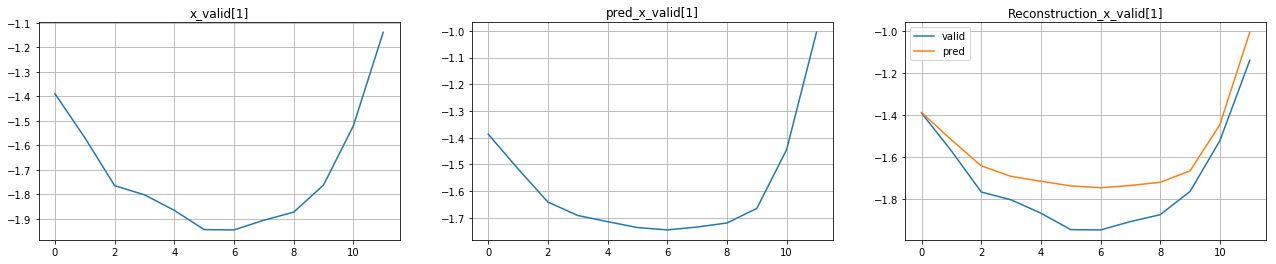

In [36]:
# Visualize the reconstruction on validation sequence[1]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[1])
plt.title('x_valid[1]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[1])
plt.title('pred_x_valid[1]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[1], label='valid')
plt.plot(pred_x_valid[1], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[1]')
plt.grid(True)
plt.show();

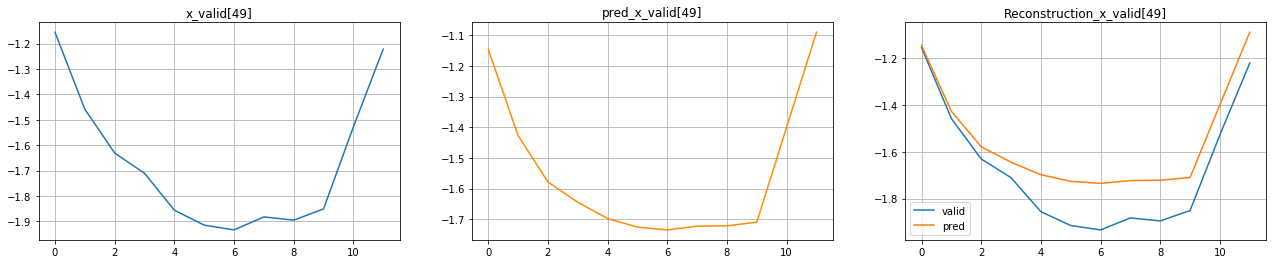

In [37]:
# Visualize the reconstruction on validation sequence[49]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_valid[49])
plt.title('x_valid[49]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_valid[49], color='darkorange')
plt.title('pred_x_valid[49]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_valid[49], label='valid')
plt.plot(pred_x_valid[49], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_valid[49]')
plt.grid(True)
plt.show();

### Summarise Model Loss Over Training Epochs

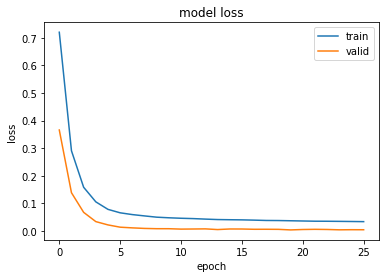

In [38]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()

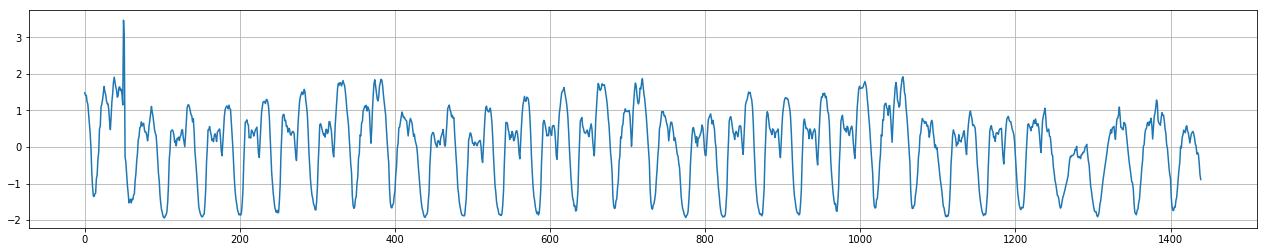

In [39]:
plt.figure(figsize=(22, 4))
plt.plot(signal_test)
plt.grid(True)

**Prepare Test Sequences: Create windows of 48 data points each**

In [40]:
test_windows = []
#contain_outliers= []

In [41]:
for window_start in range(0, len(signal_test) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_test[window_range])
    #is_outlier = len(set(window_range).intersection(set(random_indices))) > 0
    #contain_outliers.append(is_outlier)
    test_windows.append(window)

In [42]:
# shape of testing set
x_test = np.array(test_windows)
x_test.shape

(1429, 12, 1)

In [43]:
pred_x_test = m.predict(x_test)

### Visualize the reconstruction on the simulated test set (select random sets)

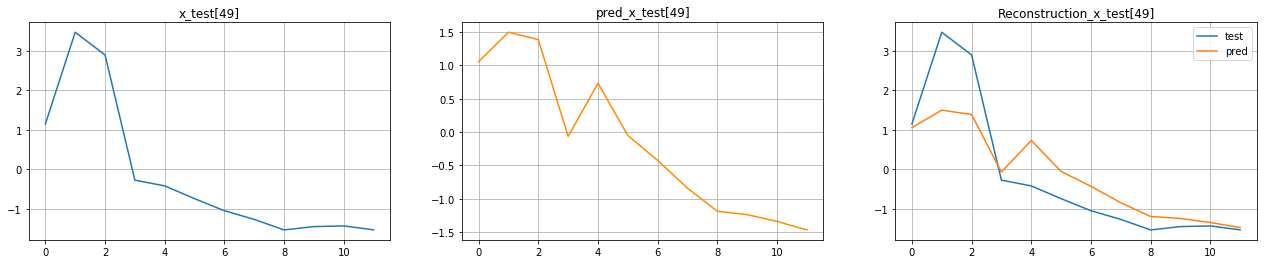

In [44]:
# Visualize the reconstruction on validation sequence[49]
plt.figure(figsize=(22, 4))
plt.subplot(131)
plt.plot(x_test[49])
plt.title('x_test[49]')
plt.grid(True)
plt.subplot(132)
plt.plot(pred_x_test[49], color='darkorange')
plt.title('pred_x_test[49]')
plt.grid(True)
plt.subplot(133)
plt.plot(x_test[49], label='test')
plt.plot(pred_x_test[49], label='pred')
plt.legend(loc='best')
plt.title('Reconstruction_x_test[49]')
plt.grid(True)
plt.show();

### Find the distribution of Reconstruction Errors on Validation and Test Set

Take the difference between the predicted values in each window with the actual value for the corresponding window in the validation set.

For each window we skip the first point in that window because the network always gives bad recontruction for the first point. 

Collect all the values and plot a distribution of the errors

In [45]:
all_errors_valid = pd.Series(np.squeeze(x_valid[:,1:,:] - pred_x_valid[:,1:,:]).flatten())
all_errors_test = pd.Series(np.squeeze(x_test[:,1:,:] - pred_x_test[:,1:,:]).flatten())

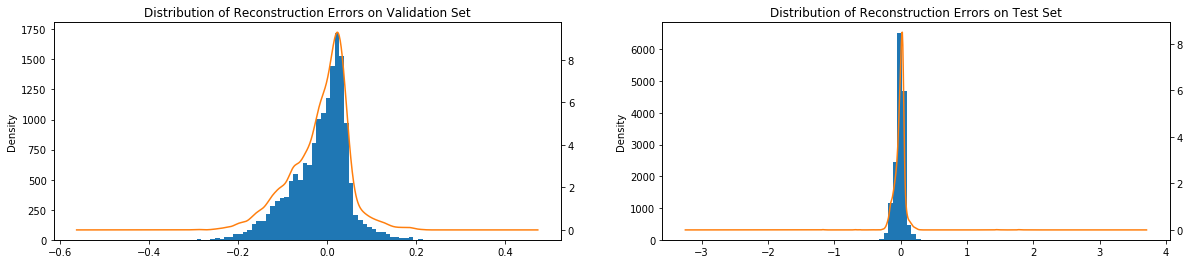

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
all_errors_valid.plot.hist(bins=50, ax=ax[0])
all_errors_valid.plot.kde(secondary_y=True, ax=ax[0])
ax[0].set_title('Distribution of Reconstruction Errors on Validation Set')
all_errors_test.plot.hist(bins=50, ax=ax[1])
all_errors_test.plot.kde(secondary_y=True, ax=ax[1])
ax[1].set_title('Distribution of Reconstruction Errors on Test Set');

### Approach 1: Rank all Test windows by comparing the probability of getting such Reconstruction Errors with those in the validation set

**Fit a Kernel Density Estimation Function on the validation errors**

In [47]:
from scipy import stats
kernel_errors = stats.gaussian_kde(all_errors_valid.values)

**Investigate the Reconstruction Errors in the Test Set**

In [48]:
errors_test_per_window = np.squeeze(x_test[:,1:,:] - pred_x_test[:,1:,:])
errors_test_per_window

array([[ 0.03704966,  0.01636505,  0.02585266, ..., -0.097747  ,
        -0.15157651, -0.14090531],
       [ 0.04725266, -0.00380757,  0.00390732, ..., -0.15470521,
        -0.14291923, -0.03938456],
       [-0.01755455, -0.0156417 ,  0.05688239, ..., -0.14686172,
        -0.04167791,  0.05405122],
       ..., 
       [ 0.0237121 ,  0.04041849,  0.04567076, ...,  0.00427375,
        -0.00350791, -0.04154864],
       [-0.00297905,  0.02843715,  0.02868504, ..., -0.00302506,
        -0.04014054, -0.04822509],
       [-0.00851261,  0.01473445,  0.00985615, ..., -0.04077065,
        -0.04810666,  0.01781441]])

In [49]:
# reconstruction errors in test set in window 0
errors_test_per_window[0]

array([  3.70496649e-02,   1.63650550e-02,   2.58526559e-02,
         3.37296723e-05,   2.97221659e-02,   5.49320638e-02,
         2.98953905e-02,  -1.88575731e-02,  -9.77469986e-02,
        -1.51576506e-01,  -1.40905309e-01])

In [50]:
# calculate the sum of probability of getting the reconstruction errors for window[0]
sum_errors_pdf_window_0 = np.sum([kernel_errors.integrate_box(error - 1e-8, error + 1e-8) for error in errors_test_per_window[0]])
sum_errors_pdf_window_0

1.2671052381879421e-06

**calculate the sum of probability of getting those errors in each window**

Apply integration to get the areas under the curve of the pdf for each error in each window and sum them up. If the reconstruction error is high, then the area under the pdf curve for that error will be low because the chance of getting that reonstruction error in normal/validation sequences in low. Sum the areas under the pdf curve for each error in a window to get a sense of measure of the degree of reconstruction error for that window.

In [51]:
def sum_errors_pdf_window(errors_in_window):
    return np.sum([kernel_errors.integrate_box(error - 1e-8, error + 1e-8) for error in errors_in_window])

In [52]:
sum_errors_pdf_per_window = pd.Series([sum_errors_pdf_window(errors_in_window) for errors_in_window in errors_test_per_window])

In [53]:
# check with our calculation for this window above
sum_errors_pdf_per_window[0]

1.2671052381879421e-06

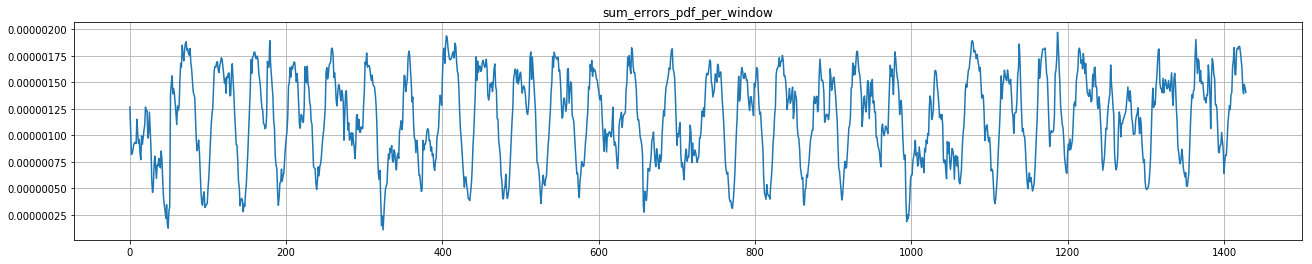

In [54]:
plt.figure(figsize=(22, 4))
plt.plot(sum_errors_pdf_per_window)
plt.title('sum_errors_pdf_per_window')
plt.grid(True, which='both');

**sort the windows by the lowest area under the pdf curve**

The lower the area under the curve, the less likely is to get those erros and hence hence more likely the window is a anomalous window

In [55]:
# Top anomalous windows ranked by area under pdf in ascending order
# we introduced anomalies in test windows 201 & 422
sum_errors_pdf_per_window.nsmallest(24)

324    1.093370e-07
49     1.259868e-07
322    1.502684e-07
48     1.589539e-07
994    1.870374e-07
996    2.157263e-07
46     2.194438e-07
323    2.414771e-07
325    2.513419e-07
995    2.522166e-07
658    2.766381e-07
145    2.807564e-07
997    2.889553e-07
50     2.897322e-07
45     2.911455e-07
771    3.122968e-07
96     3.213419e-07
770    3.242095e-07
51     3.275505e-07
147    3.306927e-07
97     3.317225e-07
141    3.369329e-07
190    3.414351e-07
93     3.421813e-07
dtype: float64

**Visualize the anomalous windows**

In [56]:
pred_outlier_indices = sum_errors_pdf_per_window.nsmallest(48).index.values
pred_outlier_indices

array([ 324,   49,  322,   48,  994,  996,   46,  323,  325,  995,  658,
        145,  997,   50,   45,  771,   96,  770,   51,  147,   97,  141,
        190,   93,  863,  657,   44,   47,   98,  146, 1107,   99,  526,
         92,  862,  768,  769,  772,  321,  435,  661,  326,  144,  911,
        142,  993, 1106,  814])

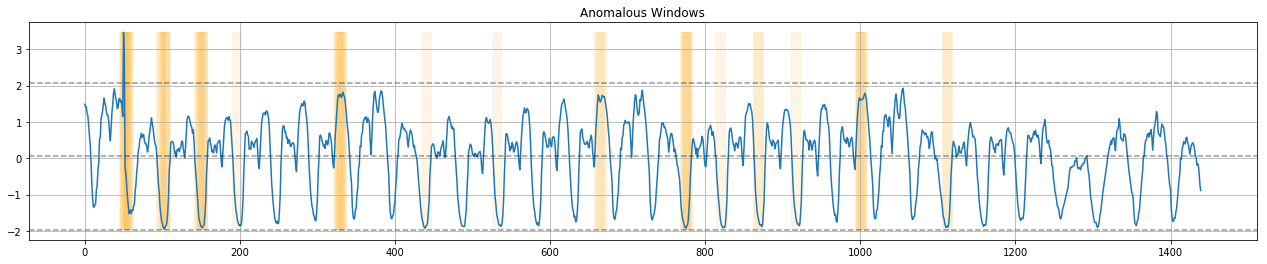

In [57]:
plt.figure(figsize=(22, 4))
plt.plot(signal_test)
plt.axhline(y=signal_test.mean(), color='k', linestyle='--', alpha=0.4) # the  horizontal line for mean
plt.axhline(y=signal_test.mean() + 2 * signal_test.std(), color='k', linestyle='--', alpha=0.4) # mean + 2 * std_dev
plt.axhline(y=signal_test.mean() - 2 * signal_test.std(), color='k', linestyle='--', alpha=0.4) # mean - 2 * std_dev
for w_index in pred_outlier_indices:
    plt.fill_betweenx((signal_test.min(), signal_test.max()), w_index, w_index + window_length - 1, alpha=0.1, color='orange')
plt.title('Anomalous Windows')
plt.grid(True);

### Approach 2: Rank all Test windows by the sum of their absolute values of the  Reconstruction Errors

In [58]:
errors_test_per_window = np.squeeze(x_test[:,1:,:] - pred_x_test[:,1:,:])
errors_test_per_window

array([[ 0.03704966,  0.01636505,  0.02585266, ..., -0.097747  ,
        -0.15157651, -0.14090531],
       [ 0.04725266, -0.00380757,  0.00390732, ..., -0.15470521,
        -0.14291923, -0.03938456],
       [-0.01755455, -0.0156417 ,  0.05688239, ..., -0.14686172,
        -0.04167791,  0.05405122],
       ..., 
       [ 0.0237121 ,  0.04041849,  0.04567076, ...,  0.00427375,
        -0.00350791, -0.04154864],
       [-0.00297905,  0.02843715,  0.02868504, ..., -0.00302506,
        -0.04014054, -0.04822509],
       [-0.00851261,  0.01473445,  0.00985615, ..., -0.04077065,
        -0.04810666,  0.01781441]])

In [59]:
# reconstruction errors in test set in window 0
errors_test_per_window[0]

array([  3.70496649e-02,   1.63650550e-02,   2.58526559e-02,
         3.37296723e-05,   2.97221659e-02,   5.49320638e-02,
         2.98953905e-02,  -1.88575731e-02,  -9.77469986e-02,
        -1.51576506e-01,  -1.40905309e-01])

In [60]:
# calculate the sum of absolute reconstruction errors for window[0]
sum_abs_errors_window_0 = np.sum(np.abs(errors_test_per_window[0]))
sum_abs_errors_window_0

0.60293711236135694

**calculate the sum of absolute values of recontruction errors in each window**

If the reconstruction error is high then the chances of that window being anomalous is high, because if the netwrok has learned well reonstructing the normal or non-anomalous subsequences/window then the reonstruction errors in those winodws will be low.

In [61]:
def sum_abs_errors_window(errors_in_window):
    return np.sum(np.abs(errors_in_window))

In [62]:
sum_abs_errors_per_window = pd.Series([sum_abs_errors_window(errors_in_window) for errors_in_window in errors_test_per_window])

In [63]:
# check with our calculation for this window above
sum_abs_errors_per_window[0]

0.60293711236135694

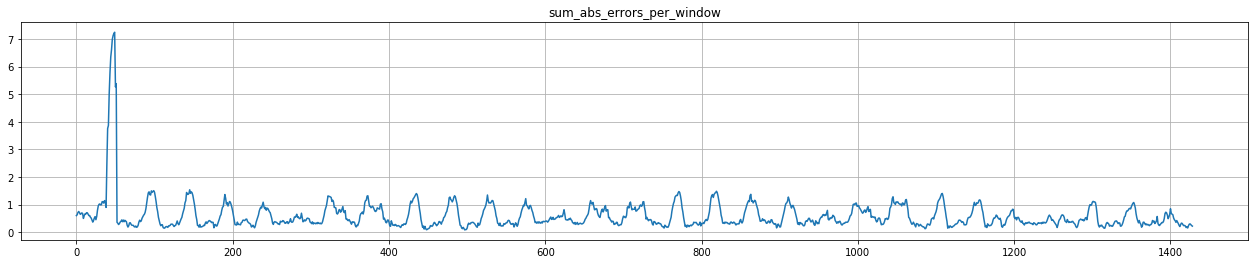

In [64]:
plt.figure(figsize=(22, 4))
plt.plot(sum_abs_errors_per_window)
plt.title('sum_abs_errors_per_window')
plt.grid(True, which='both');

**sort the windows by the highest absolute value of reconstruction errors**

The higher the sum of the reconstruction errors the more likely the window is a anomalous window because the sum of reconstruction errors for non-anomalous windows should be low

In [65]:
# Top anomalous windows ranked sum of the reconstruction errors in descending order
# we introduced anomalies in test windows 201 & 422
sum_abs_errors_per_window.nlargest(24)

49     7.242594
48     7.199708
47     7.119013
46     6.990716
45     6.617779
44     6.347511
43     5.776811
51     5.381987
50     5.267479
42     5.017629
41     3.869003
40     3.755158
39     2.448040
145    1.538210
99     1.505963
96     1.498211
819    1.485623
98     1.480670
771    1.475147
147    1.464992
93     1.464329
100    1.448777
97     1.444417
141    1.440657
dtype: float64

In [66]:
pred_outlier_indices = sum_abs_errors_per_window.nlargest(48).index.values
pred_outlier_indices

array([  49,   48,   47,   46,   45,   44,   43,   51,   50,   42,   41,
         40,   39,  145,   99,   96,  819,   98,  771,  147,   93,  100,
         97,  141,  772,  820,  818,  148,  770,   92,  817,  146, 1108,
        144,  435, 1107,  863,  142,  143,  816,  436,  190,  814,   94,
        434,  526,   95,  149])

**Visualize the anomalous windows**

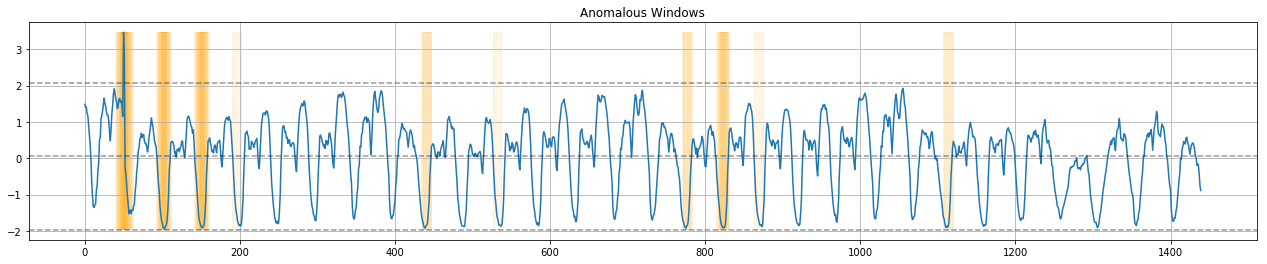

In [67]:
plt.figure(figsize=(22, 4))
plt.plot(signal_test)
plt.axhline(y=signal_test.mean(), color='k', linestyle='--', alpha=0.4) # the  horizontal line for mean
plt.axhline(y=signal_test.mean() + 2 * signal_test.std(), color='k', linestyle='--', alpha=0.4) # mean + 2 * std_dev
plt.axhline(y=signal_test.mean() - 2 * signal_test.std(), color='k', linestyle='--', alpha=0.4) # mean - 2 * std_dev
for w_index in pred_outlier_indices:
    plt.fill_betweenx((signal_test.min(), signal_test.max()), w_index, w_index + window_length - 1, alpha=0.1, color='orange')
plt.title('Anomalous Windows')
plt.grid(True);

### Approach 3: Create a threshold from the distribution of the Reconstruction Errors and Select Test windows that fall outside that threshold range to be marked as anomalous

In [68]:
max_mae_of_predictions = np.squeeze(np.max(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
#max_mae_of_predictions

In [69]:
avg_mae_of_predictions = np.squeeze(np.mean(np.square(x_test[:,1:,:] - pred_x_test[:,1:,:]), axis=1))
#avg_mae_of_predictions

In [70]:
df = pd.DataFrame(data=np.c_[max_mae_of_predictions, avg_mae_of_predictions], 
                  columns=['max_mae_of_predictions', 'avg_mae_of_predictions'])
df.sample(3)

,max_mae_of_predictions,avg_mae_of_predictions
188,0.026295,0.009637
9,0.015497,0.003282
583,0.031792,0.008661


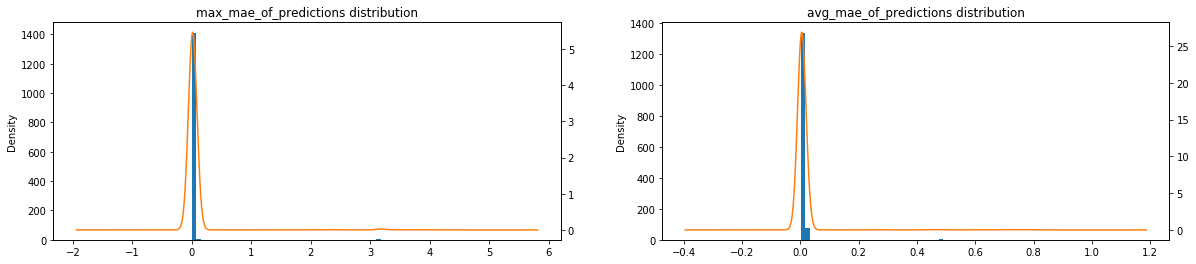

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
df['max_mae_of_predictions'].plot.hist(bins=50, ax=ax[0])
df['max_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[0])
ax[0].set_title('max_mae_of_predictions distribution')
df['avg_mae_of_predictions'].plot.hist(bins=50, ax=ax[1])
df['avg_mae_of_predictions'].plot.kde(secondary_y=True, ax=ax[1])
ax[1].set_title('avg_mae_of_predictions distribution');

In [72]:
from scipy import stats
kernel_max_mae = stats.gaussian_kde(df['max_mae_of_predictions'].values)
kernel_avg_mae = stats.gaussian_kde(df['avg_mae_of_predictions'].values)

In [73]:
df['pdf_max_mae'] = df['max_mae_of_predictions'].map(lambda x: kernel_max_mae.integrate_box(x - 1e-8, x + 1e-8))
df['pdf_avg_mae'] = df['avg_mae_of_predictions'].map(lambda x: kernel_avg_mae.integrate_box(x - 1e-8, x + 1e-8))

In [74]:
# Top anomalous points by max_mae
df.nlargest(10, columns=['pdf_max_mae'])

,max_mae_of_predictions,avg_mae_of_predictions,pdf_max_mae,pdf_avg_mae
1028,0.014953,0.003160,1.094501e-07,5.362698e-07
566,0.014791,0.002812,1.094500e-07,5.350811e-07
520,0.014791,0.005243,1.094500e-07,5.370512e-07
1399,0.014771,0.004673,1.094500e-07,5.379165e-07
231,0.014993,0.003250,1.094500e-07,5.365286e-07
521,0.015007,0.006710,1.094499e-07,5.311433e-07
1098,0.014746,0.003653,1.094499e-07,5.374364e-07
241,0.015081,0.007752,1.094497e-07,5.238274e-07
296,0.014635,0.003573,1.094495e-07,5.372878e-07
242,0.015146,0.007899,1.094494e-07,5.225910e-07


In [75]:
# Top anomalous points by avg_mae
df.nlargest(10, columns=['pdf_avg_mae'])

,max_mae_of_predictions,avg_mae_of_predictions,pdf_max_mae,pdf_avg_mae
956,0.012459,0.004368,1.093885e-07,5.380465e-07
991,0.013433,0.004388,1.094281e-07,5.380451e-07
777,0.017071,0.004312,1.093998e-07,5.380449e-07
1035,0.026944,0.004286,1.079344e-07,5.380415e-07
16,0.018791,0.004426,1.092898e-07,5.380398e-07
1036,0.027087,0.004429,1.078984e-07,5.380392e-07
669,0.025805,0.004439,1.082053e-07,5.380370e-07
1403,0.011676,0.004250,1.093422e-07,5.380341e-07
958,0.010559,0.004250,1.092540e-07,5.380340e-07
1161,0.022107,0.004246,1.089037e-07,5.380331e-07


In [76]:
max_mae_threshold = np.mean(max_mae_of_predictions) + np.std(max_mae_of_predictions)  # can use a running mean instead.
max_mae_threshold

0.34516772556432795

**Visualize the max_mae_of_predictions**

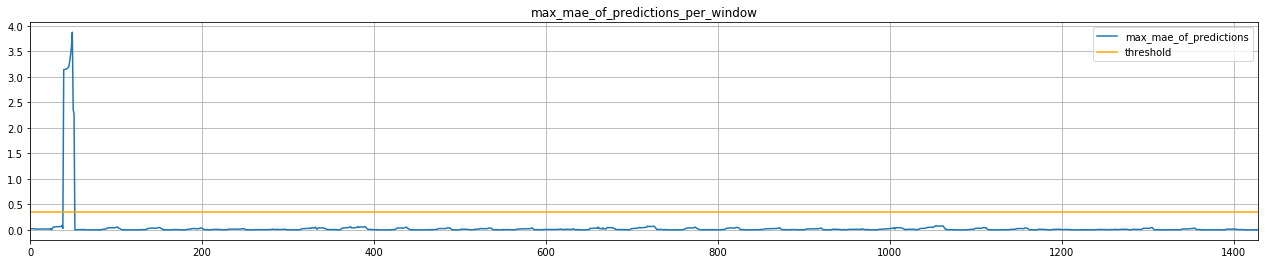

In [77]:
plt.figure(figsize=(22, 4))
df['max_mae_of_predictions'].plot()
plt.axhline(y=max_mae_threshold, color='orange', label='threshold')
plt.legend(loc='best')
plt.title('max_mae_of_predictions_per_window')
plt.grid(True, which='both');

In [78]:
pred_outlier_indices = np.where(max_mae_of_predictions > max_mae_threshold)[0]
pred_outlier_indices

array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [79]:
len(pred_outlier_indices)

13

**Visualize the anomalous windows**

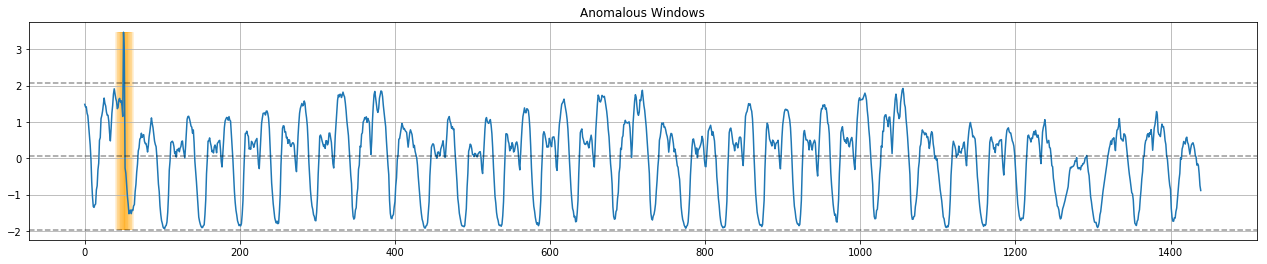

In [80]:
plt.figure(figsize=(22, 4))
plt.plot(signal_test)
plt.axhline(y=signal_test.mean(), color='k', linestyle='--', alpha=0.4) # the  horizontal line for mean
plt.axhline(y=signal_test.mean() + 2 * signal_test.std(), color='k', linestyle='--', alpha=0.4) # mean + 2 * std_dev
plt.axhline(y=signal_test.mean() - 2 * signal_test.std(), color='k', linestyle='--', alpha=0.4) # mean - 2 * std_dev
for w_index in pred_outlier_indices:
    plt.fill_betweenx((signal_test.min(), signal_test.max()), w_index, w_index + window_length - 1, alpha=0.1, color='orange')
plt.title('Anomalous Windows')
plt.grid(True);